In [21]:
# imports some utilities ...
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

In [22]:
#defines routes

root_dir = "./"
data_dir = root_dir + "dataset/chest_xray/"

training_images_dir =  data_dir + "train/"
test_images_dir = data_dir + "test/"

training_images_dir

'./dataset/chest_xray/train/'

## Let's visualizate

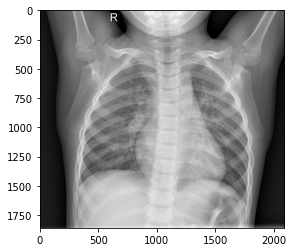

In [23]:
# Load an color image in grayscale
img = cv2.imread(training_images_dir + "/NORMAL/IM-0115-0001.jpeg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # RGB colorisation
plt.imshow(img_rgb)

In [24]:
def list_folders(startpath):
    """Print the folder sutructure of a given folder"""
    
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))

In [25]:
# defines class

categories = [
    ["NORMAL"],
    ["PNEUMONIA"]
]

In [26]:
type(img)
img_rgb.shape

(1858, 2090, 3)

In [27]:
from tensorflow.keras import layers, models
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# with tf.device('/GPU:0'):

input_size_1 = 270
input_size_2 = 300
dim = 3

kernel_size = (10, 10)
output_size = len(categories)
print("Output size :", output_size)

Num GPUs Available:  1
Output size : 2


## Datagen

In [28]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(
        training_images_dir,
        target_size=(input_size_1, input_size_2),
        color_mode="rgb",
        class_mode="binary",
        batch_size=32,
        shuffle=True,
        seed=42
)

Found 5216 images belonging to 2 classes.


In [29]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(
        test_images_dir,
        target_size=(input_size_1, input_size_2),
        color_mode="rgb",
        class_mode="binary",
        batch_size=32,
        shuffle=True,
        seed=42
)

Found 624 images belonging to 2 classes.


In [30]:
train_iter = iter(train_datagen)
train = train_iter.next()
train[0].shape

(32, 270, 300, 3)

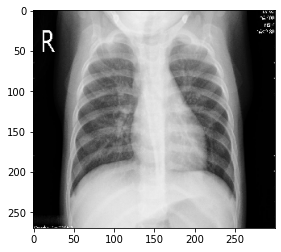

In [31]:
img = cv2.imread(training_images_dir + "/NORMAL/IM-0115-0001.jpeg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # RGB colorisation
plt.imshow(train[0][0].astype(int))

In [32]:
print("input size : ",input_size_1, input_size_2)
print("dim : ", dim)
print("kernel size : ", kernel_size)
output_size = output_size - 1 # For sigmoid activation its betwteen 0 and 1 
print("output size : ", output_size)


input size :  270 300
dim :  3
kernel size :  (10, 10)
output size :  1


In [34]:
def input_size_sequential(input_size_1, input_size_2, dim):
    return (input_size_1, input_size_2, dim)

In [35]:
input_size_sequential(input_size_1, input_size_2, dim)

(270, 300, 3)

In [41]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size = kernel_size, activation='relu', input_shape=input_size_sequential(input_size_1, input_size_2, dim)))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, kernel_size = kernel_size, activation='relu'))
model.add(layers.Conv2D(64, kernel_size = kernel_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, kernel_size = kernel_size, activation='relu'))
model.add(layers.Conv2D(128, kernel_size = kernel_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, kernel_size = (5, 5), activation='relu'))
model.add(layers.Conv2D(256, kernel_size = (3, 3), activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Flatten()) # 2d to 1d

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(output_size, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 261, 291, 32)      9632      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 131, 146, 32)      0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 131, 146, 32)      128       
_________________________________________________________________
dropout_15 (Dropout)         (None, 131, 146, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 122, 137, 64)      204864    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 113, 128, 64)      409664    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 57, 64, 64)       

In [53]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy', tf.keras.metrics.Recall()])

In [ ]:
with tf.device('/GPU:0'):

    history = model.fit(train_datagen, epochs=10, 
                        validation_data=test_datagen)

Epoch 1/10
163/163 [==============================] - 73s 440ms/step - loss: 0.4098 - binary_accuracy: 0.7417 - accuracy: 0.7417 - recall: 0.9958 - val_loss: 0.5581 - val_binary_accuracy: 0.6923 - val_accuracy: 0.6923 - val_recall: 0.9615
Epoch 2/10
163/163 [==============================] - 72s 438ms/step - loss: 0.3661 - binary_accuracy: 0.7726 - accuracy: 0.7726 - recall: 0.9163 - val_loss: 1.8326 - val_binary_accuracy: 0.8333 - val_accuracy: 0.8333 - val_recall: 0.9744
Epoch 3/10
163/163 [==============================] - 71s 437ms/step - loss: 0.3260 - binary_accuracy: 0.8763 - accuracy: 0.8763 - recall: 0.8598 - val_loss: 0.4983 - val_binary_accuracy: 0.8045 - val_accuracy: 0.8045 - val_recall: 0.9205
Epoch 4/10
163/163 [==============================] - 71s 437ms/step - loss: 0.3166 - binary_accuracy: 0.8668 - accuracy: 0.8668 - recall: 0.8489 - val_loss: 0.6457 - val_binary_accuracy: 0.8221 - val_accuracy: 0.8221 - val_recall: 0.9538
Epoch 5/10
163/163 [========================

20/20 - 5s - loss: 1.6284 - accuracy: 0.6250


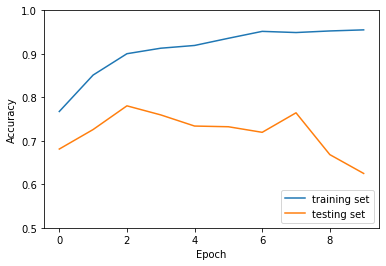

In [19]:
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label = 'testing set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_datagen, verbose=2)